# **Dependencies**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers

In [3]:
import pickle
import re
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import transformers
import torch.utils.data as tdata
import torch.optim as optim

from transformers import AutoModel, AutoTokenizer, BertForSequenceClassification

import tqdm

# **Data Prep**

In [4]:
with open('/content/drive/My Drive/AI_n_Music/axe.pkl', 'rb') as file:
    lyrics_axe = pickle.load(file)
with open('/content/drive/My Drive/AI_n_Music/funk.pkl', 'rb') as file:
    lyrics_funk = pickle.load(file)
with open('/content/drive/My Drive/AI_n_Music/mpb.pkl', 'rb') as file:
    lyrics_mpb = pickle.load(file)
with open('/content/drive/My Drive/AI_n_Music/pagode.pkl', 'rb') as file:
    lyrics_pagode = pickle.load(file)
with open('/content/drive/My Drive/AI_n_Music/samba.pkl', 'rb') as file:
    lyrics_samba = pickle.load(file)
with open('/content/drive/My Drive/AI_n_Music/sertanejo.pkl', 'rb') as file:
    lyrics_sertanejo = pickle.load(file)

In [5]:
lyrics = []
for lyric in lyrics_axe:
  l = lyric[3].replace('</p>', '\n').replace('<p>', '\n').replace('<br>', '\n').replace('<br/>', '\n').replace('</br>', '\n').replace('\n\n\n', '\n\n').lower()
  l = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', '', l)
  lyrics.append(('axe', l))
for lyric in lyrics_funk:
  l = lyric[3].replace('</p>', '\n').replace('<p>', '\n').replace('<br>', '\n').replace('<br/>', '\n').replace('</br>', '\n').replace('\n\n\n', '\n\n').lower()
  l = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', '', l)
  lyrics.append(('funk', l))
for lyric in lyrics_mpb:
  l = lyric[3].replace('</p>', '\n').replace('<p>', '\n').replace('<br>', '\n').replace('<br/>', '\n').replace('</br>', '\n').replace('\n\n\n', '\n\n').lower()
  l = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', '', l)
  lyrics.append(('mpb', l))
for lyric in lyrics_pagode:
  l = lyric[3].replace('</p>', '\n').replace('<p>', '\n').replace('<br>', '\n').replace('<br/>', '\n').replace('</br>', '\n').replace('\n\n\n', '\n\n').lower()
  l = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', '', l)
  lyrics.append(('pagode', l))
for lyric in lyrics_samba:
  l = lyric[3].replace('</p>', '\n').replace('<p>', '\n').replace('<br>', '\n').replace('<br/>', '\n').replace('</br>', '\n').replace('\n\n\n', '\n\n').lower()
  l = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', '', l)
  lyrics.append(('samba', l))
for lyric in lyrics_sertanejo:
  l = lyric[3].replace('</p>', '\n').replace('<p>', '\n').replace('<br>', '\n').replace('<br/>', '\n').replace('</br>', '\n').replace('\n\n\n', '\n\n').lower()
  l = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', '', l)
  lyrics.append(('sertanejo', l))

In [6]:
data = []
for ix, lyric in enumerate(lyrics):
  if len(lyric[1].split()) == 0:
    continue
  data.append((ix, lyric[0], lyric[1]))

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
np.unique([genre for _, genre, _ in data])

array(['axe', 'funk', 'mpb', 'pagode', 'samba', 'sertanejo'], dtype='<U9')

In [9]:
len(np.unique([genre for _, genre, _ in data]))

6

In [10]:
data_train, data_valid = train_test_split(data, test_size=0.33, random_state=12345)

In [11]:
X_data_train = [lyric for _, _, lyric in data_train]
X_data_valid = [lyric for _, _, lyric in data_valid]
Y_data_train = [genre for _, genre, _ in data_train]
Y_data_valid = [genre for _, genre, _ in data_valid]

In [12]:
le = LabelEncoder()
Y_data_train_2 = le.fit_transform(Y_data_train)
Y_data_valid_2 = le.transform(Y_data_valid)

In [13]:
le.classes_

array(['axe', 'funk', 'mpb', 'pagode', 'samba', 'sertanejo'], dtype='<U9')

# **Modelling**

## **Model 1 - Bag of Words - TFIDF**

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
from nltk.corpus import stopwords

In [16]:
cv = TfidfVectorizer(stop_words=stopwords.words('portuguese'))

In [17]:
X_data_train_2 = cv.fit_transform(X_data_train)
X_data_valid_2 = cv.transform(X_data_valid)

In [18]:
param_dist = dict(vectorizer__ngram_range = [(1,2), (1, 2), (1, 3)],
                  sfm__k=list(range(1, 10000)),
                  logistic__C=uniform(loc=0, scale=4),
                  logistic__penalty=['l2', 'l1'])

In [19]:
# create pipeline with a scaler 
steps = []
steps.append(('vectorizer', cv))
steps.append(('sfm', SelectKBest(chi2)))
steps.append(('logistic', LogisticRegression(solver='liblinear', max_iter=200, random_state=12345)))
pipeline = Pipeline(steps)

# do search
search = RandomizedSearchCV(pipeline, param_distributions=param_dist)
search.fit(X_data_train, Y_data_train_2)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('vectorizer',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                               

In [20]:
search.best_params_

{'logistic__C': 3.245965174441233,
 'logistic__penalty': 'l2',
 'sfm__k': 9740,
 'vectorizer__ngram_range': (1, 2)}

In [21]:
results = []

In [22]:
print('Train Accuracy', accuracy_score(Y_data_train_2, search.predict(X_data_train)))
print('Valid Accuracy', accuracy_score(Y_data_valid_2, search.predict(X_data_valid)))

Train Accuracy 0.8267363704256908
Valid Accuracy 0.5621212121212121


In [23]:
results.append(['Bag of Words - TFIDF',
      accuracy_score(Y_data_train_2, search.predict(X_data_train)),
      accuracy_score(Y_data_valid_2, search.predict(X_data_valid))
])

## **Model 2 - Continuous Skipgram - Pre-Trained**

In [24]:
errors = []
embeddings_index = {}
f = open('/content/drive/My Drive/Data Master/skip_s50.txt')
for line in f:
    values = line.split()
    word = values[0]
    try:
      coefs = np.asarray(values[1:], dtype='float32')
    except:
      errors.append(line)
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 929595 word vectors.


In [25]:
print(len(embeddings_index))
print(len(errors))

929595
4


In [26]:
EMBEDDING_DIM = 50
errors_2 = []
nomatchs = []

X_train_matrix = np.zeros((len(X_data_train), EMBEDDING_DIM))
X_valid_matrix = np.zeros((len(X_data_valid), EMBEDDING_DIM))

In [27]:
for i, x in enumerate(X_data_train):
  for w in x.split():
    embedding_vector = embeddings_index.get(w)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        try:
          X_train_matrix[i] += embedding_vector
        except:
          errors_2.append([word, len(embedding_vector), embedding_vector])
    else:
      nomatchs.append(word)

In [28]:
for i, x in enumerate(X_data_valid):
  for w in x.split():
    embedding_vector = embeddings_index.get(w)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        try:
          X_valid_matrix[i] += embedding_vector
        except:
          errors_2.append([word, len(embedding_vector), embedding_vector])
    else:
      nomatchs.append(word)

In [29]:
X_train_matrix.shape

(4017, 50)

In [30]:
X_valid_matrix.shape

(1980, 50)

In [31]:
param_dist = dict(logistic__C=uniform(loc=0, scale=4),
                  logistic__penalty=['l2', 'l1'])

In [32]:
# create pipeline with a scaler 
steps = []
steps.append(('scaler', StandardScaler()))
steps.append(('logistic', LogisticRegression(solver='liblinear', max_iter=200, random_state=12345)))
pipeline = Pipeline(steps)

# do search
search = RandomizedSearchCV(pipeline, param_distributions=param_dist)
search.fit(X_train_matrix, Y_data_train_2)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('logistic',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=200,


In [33]:
print('Train Accuracy', accuracy_score(Y_data_train_2, search.predict(X_train_matrix)))
print('Valid Accuracy', accuracy_score(Y_data_valid_2, search.predict(X_valid_matrix)))

Train Accuracy 0.4627831715210356
Valid Accuracy 0.43383838383838386


In [34]:
results.append(['Skipgram - Pre-Trained',
      accuracy_score(Y_data_train_2, search.predict(X_train_matrix)),
      accuracy_score(Y_data_valid_2, search.predict(X_valid_matrix))
])

## **Model 3 - Continuous Skipgram - Task-Specific**

In [35]:
from gensim.models import Word2Vec

In [36]:
model = Word2Vec(sentences=[sentence.split() for sentence in X_data_train], size=50, window=5, min_count=1, workers=4, sg=1)

In [37]:
EMBEDDING_DIM = 50
errors_2 = []
nomatchs = []

X_train_matrix = np.zeros((len(X_data_train), EMBEDDING_DIM))
X_valid_matrix = np.zeros((len(X_data_valid), EMBEDDING_DIM))

In [38]:
for i, x in enumerate(X_data_train):
  for w in x.split():
    if w in model.wv:
      embedding_vector = model.wv[w]
      try:
        X_train_matrix[i] += embedding_vector
      except:
        errors_2.append([word, len(embedding_vector), embedding_vector])
    else:
      nomatchs.append(word)

In [39]:
for i, x in enumerate(X_data_valid):
  for w in x.split():
    if w in model.wv:
      embedding_vector = model.wv[w]
      try:
        X_valid_matrix[i] += embedding_vector
      except:
        errors_2.append([word, len(embedding_vector), embedding_vector])
    else:
      nomatchs.append(word)

In [40]:
X_train_matrix.shape

(4017, 50)

In [41]:
X_valid_matrix.shape

(1980, 50)

In [42]:
param_dist = dict(logistic__C=uniform(loc=0, scale=4),
                  logistic__penalty=['l2', 'l1'])

In [43]:
# create pipeline with a scaler 
steps = []
steps.append(('scaler', StandardScaler()))
steps.append(('logistic', LogisticRegression(solver='liblinear', max_iter=200, random_state=12345)))
pipeline = Pipeline(steps)

# do search
search = RandomizedSearchCV(pipeline, param_distributions=param_dist)
search.fit(X_train_matrix, Y_data_train_2)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('logistic',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=200,


In [44]:
print('Train Accuracy', accuracy_score(Y_data_train_2, search.predict(X_train_matrix)))
print('Valid Accuracy', accuracy_score(Y_data_valid_2, search.predict(X_valid_matrix)))

Train Accuracy 0.5048543689320388
Valid Accuracy 0.4954545454545455


In [45]:
results.append(['Skipgram - Task-Specific',
      accuracy_score(Y_data_train_2, search.predict(X_train_matrix)),
      accuracy_score(Y_data_valid_2, search.predict(X_valid_matrix))
])

## **Model 4 - BERT**

### **Importing Pre-Trained Model**

In [46]:
bert_tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', )
#bert_model = BertForSequenceClassification.from_pretrained('neuralmind/bert-large-portuguese-cased').to(device)
bert_model = BertForSequenceClassification.from_pretrained(
    'neuralmind/bert-base-portuguese-cased', # Use the 12-layer BERT model, with an uncased vocab. 
    num_labels = 6, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

### **Data Preparation**

In [47]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_train = []
attention_masks_train = []

# For every sentence...
for lyric in tqdm.notebook.tqdm(data_train):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    sent = lyric[2]
    encoded_dict = bert_tokenizer.encode_plus(
                        sent, # Sentence A to encode.                 
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_train.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_train.append(encoded_dict['attention_mask'])


# Convert the lists into tensors.
input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)

# Print sentence 0, now as a list of IDs.
#print('Original: ', sentences_train[3000])
#print('Token IDs:', input_ids_train[3000])

In [48]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_valid = []
attention_masks_valid = []

# For every sentence...
for lyric in tqdm.notebook.tqdm(data_valid):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    sent = lyric[2]
    encoded_dict = bert_tokenizer.encode_plus(
                        sent, # Sentence to encode.                     
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_valid.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_valid.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_valid = torch.cat(input_ids_valid, dim=0)
attention_masks_valid = torch.cat(attention_masks_valid, dim=0)

# Print sentence 0, now as a list of IDs.
#print('Original: ', sentences_valid[3000])
#print('Token IDs:', input_ids_valid[3000])

In [49]:
labels_train = torch.tensor(Y_data_train_2)
labels_valid = torch.tensor(Y_data_valid_2)

In [50]:
input_ids_train.shape

torch.Size([4017, 512])

In [51]:
labels_train.shape

torch.Size([4017])

In [52]:
from torch.utils.data import TensorDataset

In [53]:
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
valid_dataset = TensorDataset(input_ids_valid, attention_masks_valid, labels_valid)

In [54]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 12

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            valid_dataset, # The validation samples.
            sampler = SequentialSampler(valid_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### **Fine Tuning - BertForSequenceClassification**

In [55]:
from transformers import AdamW, BertConfig
# Tell pytorch to run this model on the GPU.
bert_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [56]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(bert_model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [57]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [58]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [59]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [60]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    total_train_accuracy = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    bert_model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        bert_model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        result = bert_model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        loss, logits = result.loss, result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        # Move logits and labels to CPU
        logits_train = logits.detach().cpu().numpy()
        label_ids_train = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_train_accuracy += flat_accuracy(logits_train, label_ids_train)

      
    # Report the final accuracy for this validation run.
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Training accuracy: {0:.2f}".format(avg_train_accuracy))
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    bert_model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            results_val = bert_model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
            loss_val, logits_val = results_val.loss, results_val.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss_val.item()

        # Move logits and labels to CPU
        logits_val = logits_val.detach().cpu().numpy()
        label_ids_val = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits_val, label_ids_val)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Validation accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Accur.': avg_train_accuracy,
            'Valid Loss': avg_val_loss,
            'Valid Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    335.    Elapsed: 0:00:46.
  Batch    80  of    335.    Elapsed: 0:01:35.
  Batch   120  of    335.    Elapsed: 0:02:24.
  Batch   160  of    335.    Elapsed: 0:03:14.
  Batch   200  of    335.    Elapsed: 0:04:04.
  Batch   240  of    335.    Elapsed: 0:04:53.
  Batch   280  of    335.    Elapsed: 0:05:43.
  Batch   320  of    335.    Elapsed: 0:06:33.

  Training accuracy: 0.47
  Average training loss: 1.37
  Training epcoh took: 0:06:51

Running Validation...
  Validation accuracy: 0.58
  Validation Loss: 1.14
  Validation took: 0:01:14

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    335.    Elapsed: 0:00:50.
  Batch    80  of    335.    Elapsed: 0:01:39.
  Batch   120  of    335.    Elapsed: 0:02:29.
  Batch   160  of    335.    Elapsed: 0:03:19.
  Batch   200  of    335.    Elapsed: 0:04:08.
  Batch   240  of    335.    Elapsed: 0:04:58.
  Batch   280  of    335.    Elapsed: 0:05:48.
  Batch   320  of  

In [61]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Training Accur.,Valid Loss,Valid Accur.,Training Time,Validation Time
epoch,,,,,,
1,1.37,0.47,1.14,0.58,0:06:51,0:01:14
2,1.00,0.64,1.02,0.61,0:06:55,0:01:14
3,0.72,0.76,1.04,0.63,0:06:55,0:01:15
4,0.55,0.83,1.04,0.63,0:06:55,0:01:15


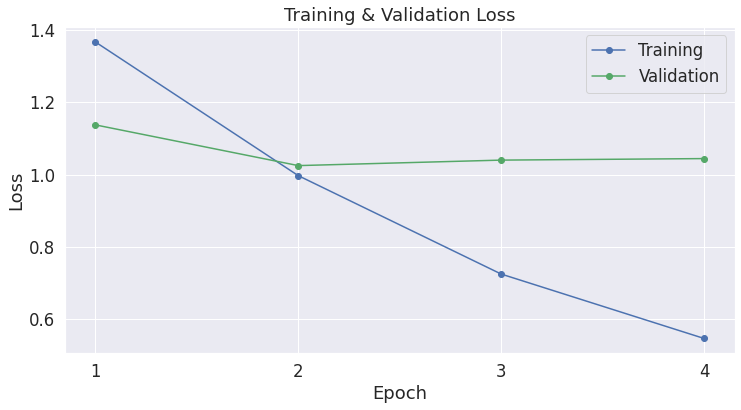

In [62]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [63]:
training_stats[-1]['Training Accur.']

0.826036484245439

In [64]:
training_stats[-1]['Valid Accur.']

0.6323232323232322

In [65]:
print('Train Accuracy', training_stats[-1]['Training Accur.'])
print('Valid Accuracy', training_stats[-1]['Valid Accur.'])

Train Accuracy 0.826036484245439
Valid Accuracy 0.6323232323232322


In [66]:
results.append(['BERT - Pre-Trained (Bertimbau)',
      training_stats[-1]['Training Accur.'],
      training_stats[-1]['Valid Accur.']
])

In [67]:
pd.DataFrame(results, columns=['Model', 'Training Accur.', 'Valid Accur.'])

,Model,Training Accur.,Valid Accur.
0,Bag of Words - TFIDF,0.83,0.56
1,Skipgram - Pre-Trained,0.46,0.43
2,Skipgram - Task-Specific,0.50,0.50
3,BERT - Pre-Trained (Bertimbau),0.83,0.63
